In [202]:
!pip install networkx
!pip install matplotlib
!pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [203]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby

## Generating graph

In [204]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

In [205]:
def weight_build_in_algorithm(mstp: object) -> int:
    """
    Weight of build in algorithm.
    """
    output_weight = 0
    conections = dict(mstp.adjacency())
    edges = mstp.edges()
    for edge in edges:
        for node_num, conection in conections.items():
            if node_num == edge[0]:
                for connected_node, weight in conection.items():
                    if connected_node == edge[1]:
                        output_weight += weight['weight']
                        break
    return output_weight

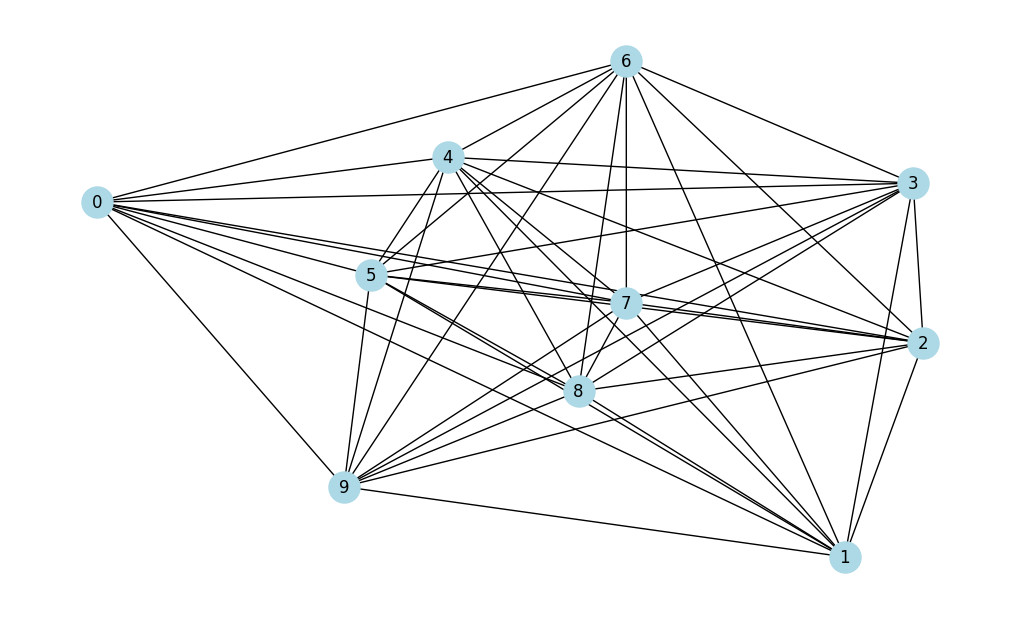

In [206]:
G = gnp_random_connected_graph(10, 1, False, True)

In [207]:
from networkx.algorithms import tree

## Prim's algorithm

In [208]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

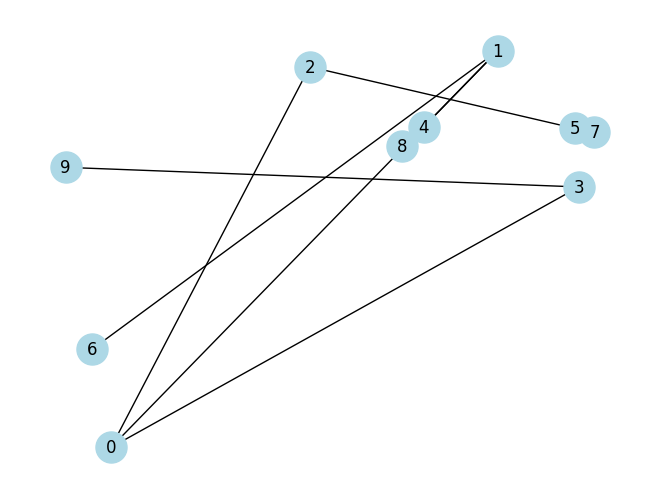

In [209]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [210]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 1), (0, 2), (0, 3), (1, 6), (1, 4), (2, 5), (3, 9), (4, 8), (5, 7)]),
 9)

In [211]:
import heapq
def has_cycle_dfs(edges: list, current: int, visited: int, parent: int) -> bool:
    """
    Depth-first search.
    """
    visited.add(current)
    for edge in edges:
        node, neighbor = edge
        if node == current:
            if neighbor not in visited:
                if has_cycle_dfs(edges, neighbor, visited, current):
                    return True
            elif neighbor != parent:
                return True
        elif neighbor == current:
            if node not in visited:
                if has_cycle_dfs(edges, node, visited, current):
                    return True
            elif node != parent:
                return True
    return False

def has_cycle(edges: list) -> bool:
    """
    Checks if the graph contains any cycles.
    >>> has_cycle([(1, 2), (2, 3), (1, 3)])
    True
    """
    visited = set()
    for edge in edges:
        node, neighbor = edge
        if node not in visited:
            if has_cycle_dfs(edges, node, visited, None):
                return True
        if neighbor not in visited:
            if has_cycle_dfs(edges, neighbor, visited, None):
                return True
        visited.add(node)
        visited.add(neighbor)
    return False

def main(G):
    """
    >>> main(G) == weight_build_in_algorithm(mstp)
    True
    """
    connections = dict(G.adjacency())
    heap = [(data['weight'], node, neighbor) for node, edges in connections.items() for neighbor, data in edges.items()]
    heapq.heapify(heap)
    visited = set([0])
    prima = []
    output_weight = 0
    while len(prima) != len(connections) - 1:
        weight, node, neighbor = heapq.heappop(heap)
        if (has_cycle(prima + [(node, neighbor)]) is False):
            visited.add(node)
            visited.add(neighbor)
            prima.append((node, neighbor))
            output_weight += weight
    return output_weight
if __name__ == '__main__':
    import doctest
    print(doctest.testmod())


TestResults(failed=0, attempted=2)


## Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [214]:
import time
from tqdm import tqdm

In [215]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:03<00:00, 328.74it/s]


0.0008434839248657227

100%|██████████| 1000/1000 [06:45<00:00,  2.47it/s]


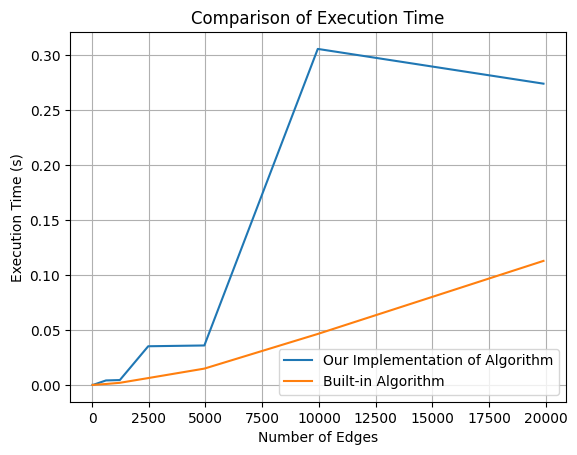

In [218]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

NUM_OF_ITERATIONS = 1000
graph_sizes = [10, 50, 100, 200]
fullness_levels = [0.5, 1]

# Initialize lists to store execution times for each algorithm
main_execution_times = []
built_in_algorithm_execution_times = []
num_edges = []

for size in graph_sizes:
    for fullness in fullness_levels:
        my_time = 0
        built_in_time = 0
        for i in tqdm(range(NUM_OF_ITERATIONS)):
            G = gnp_random_connected_graph(size, fullness, False, False)
            
            # Measure execution time for main algorithm
            start_main_execution = time.time()
            main_execution_time = main(G)
            end_main_execution = time.time()
            my_time += end_main_execution - start_main_execution
            
            # Measure execution time for built-in algorithm
            start_built_in_execution = time.time()
            build_in_algorithm_execution_time = weight_build_in_algorithm(G)
            end_built_in_execution = time.time()
            built_in_time += end_built_in_execution - start_built_in_execution
        
        main_execution_times.append(my_time / 1000)
        built_in_algorithm_execution_times.append(built_in_time / 1000)
        num_edges.append(size * (size - 1) / 2 * fullness)

# Plot the results
plt.plot(num_edges, main_execution_times, label='Our Implementation of Algorithm')
plt.plot(num_edges, built_in_algorithm_execution_times, label='Built-in Algorithm')
plt.xlabel('Number of Edges')
plt.ylabel('Execution Time (s)')
plt.title('Comparison of Execution Time')
plt.legend()
plt.grid(True)
plt.show()
